In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-01 19:48:44.096472: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 19:48:44.125689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 19:48:44.578054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')
df_totais = pd.DataFrame(df[['Ano','TOTAL_CRUSTACEOS_M','TOTAL_CRUSTACEOS_F&M']])

dados = df_totais.dropna().reset_index(drop=True)

#Fazendo as proporções de ostra_art em relação a mexilhao_art
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_TOTAL_CRUSTACEOS_M'] = dados.loc[i,'TOTAL_CRUSTACEOS_M'] / dados.loc[i,'TOTAL_CRUSTACEOS_F&M']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1965,1974])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()


prop = dados['Prop_TOTAL_CRUSTACEOS_M'].values
dados.head()

,Ano,TOTAL_CRUSTACEOS_M,TOTAL_CRUSTACEOS_F&M,Prop_TOTAL_CRUSTACEOS_M
0,1962,1812.0,1924.0,0.941788
1,1963,2055.0,2385.0,0.861635
2,1964,2230.0,2343.0,0.951771
3,1966,2482.0,2494.0,0.995188
4,1967,3814.0,4012.0,0.950648


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Totais/pesos TOTAL_CRUSTACEOS_M/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Totais/pesos TOTAL_CRUSTACEOS_M/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.99419725]
 [0.9860746 ]
 [0.9778408 ]
 [0.96926504]
 [0.96069574]
 [0.9521277 ]
 [0.9435595 ]
 [0.9349564 ]
 [0.92608905]
 [0.91722214]
 [0.90815896]
 [0.8989845 ]
 [0.92489094]
 [0.7982096 ]]


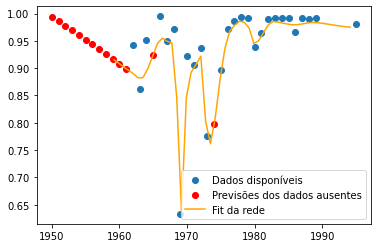

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

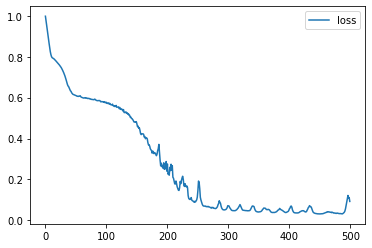

In [17]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [7]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para TOTAL_CRUSTACEOS_F&M
df_prev_FM = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Totais/Previsão TOTAL_CRUSTACEOS_F&M_1950-1955.xlsx')


for i in range(len(df_prev_FM['Ano'])):
    if pd.isnull(df.loc[i,'TOTAL_CRUSTACEOS_F&M'])==True:
       df.loc[i,'TOTAL_CRUSTACEOS_F&M'] = df_prev_FM.loc[i,'TOTAL_CRUSTACEOS_F&M']


df_preenchido = df[['Ano','TOTAL_CRUSTACEOS_M']]
for i in range(len(prev_continua)):
    if pd.isnull(df.loc[i,'TOTAL_CRUSTACEOS_M'])==True:
      df_preenchido.loc[i,'TOTAL_CRUSTACEOS_M']=df.loc[i,'TOTAL_CRUSTACEOS_F&M']*prev_continua[i]


with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Totais/Previsão TOTAL_CRUSTACEOS_M_1950-1974.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     Ano  TOTAL_CRUSTACEOS_M
0   1950         2004.962646
1   1951         1898.692017
2   1952         1790.668335
3   1953         1600.007812
4   1954         1436.618652
5   1955         1731.325195
6   1956         1280.410278
7   1957          958.330261
8   1958         1240.033203
9   1959         1967.441528
10  1960         1188.780029
11  1961          893.590576
12  1962         1812.000000
13  1963         2055.000000
14  1964         2230.000000
15  1965         2490.731201
16  1966         2482.000000
17  1967         3814.000000
18  1968         6503.000000
19  1969         3766.000000
20  1970         5715.000000
21  1971         4936.000000
22  1972         6144.000000
23  1973         9736.000000
24  1974         2380.260986
25  1975         8185.000000
26  1976         3543.000000
27  1977         9064.000000
28  1978        24835.000000
29  1979        21827.000000
30  1980         3519.000000
31  1981         3190.500000
32  1